# Importing libraries

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
import keras
import sys, time, os, warnings
import numpy as np
import pandas as pd
from collections import Counter
from copy import copy
warnings.filterwarnings("ignore")

In [2]:
from keras.preprocessing.image import load_img, img_to_array
from IPython.display import display
from PIL import Image
import string

In [3]:
from tensorflow.keras.applications import VGG16
from keras import models
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict
from sklearn.decomposition import PCA
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [74]:
from keras import layers
from keras.layers import Input, Flatten, Dropout, Activation, Bidirectional
from keras.layers.advanced_activations import LeakyReLU, PReLU
from time import time
from keras.callbacks import TensorBoard

In [4]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
#Using 95% of the available memory of the GPU
config.gpu_options.visible_device_list = "0"
set_session(tf.compat.v1.Session(config=config))

In [5]:
def set_seed(sd=144):
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn
    ## numpy random seed
    seed(sd)
    ## core python's random number 
    rn.seed(sd)
    ## tensor flow's random number
    set_random_seed(sd)

# Importing dataset

Here, we are importing both the image dataset and respective captions.

In [6]:
dir_Flickr_imgs = "dataset/images/"
dir_Flickr_text = "dataset/captions.txt"

jpgs = os.listdir(dir_Flickr_imgs)
print("The number of images in the Flicker8k dataset are: {}".format(len(jpgs)))

The number of images in the Flicker8k dataset are: 8091


In [7]:
# Reading the captions for each image.
with open(dir_Flickr_text, "r", encoding="utf-8") as file:
    text = file.read()

data_txt = []
temp = text.split("\n")
index = 0
for i in range(len(temp) - 1):
    if i == 0:
        continue
    index = i - 1
    col = temp[i].split(".jpg,")
    col[0] += ".jpg"
    col[1] = col[1].lower()
    col.insert(1, index)
    data_txt.append(col)

df_txt = pd.DataFrame(data_txt, columns=["filename", "index", "caption"])


uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique filenames: {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.filename.values).values())
print(df_txt[:5])

The number of unique filenames: 8091
The distribution of the number of captions for each image:
                    filename  index  \
0  1000268201_693b08cb0e.jpg      0   
1  1000268201_693b08cb0e.jpg      1   
2  1000268201_693b08cb0e.jpg      2   
3  1000268201_693b08cb0e.jpg      3   
4  1000268201_693b08cb0e.jpg      4   

                                             caption  
0  a child in a pink dress is climbing up a set o...  
1              a girl going into a wooden building .  
2   a little girl climbing into a wooden playhouse .  
3  a little girl climbing the stairs to her playh...  
4  a little girl in a pink dress going into a woo...  


### Plotting sample images and captions

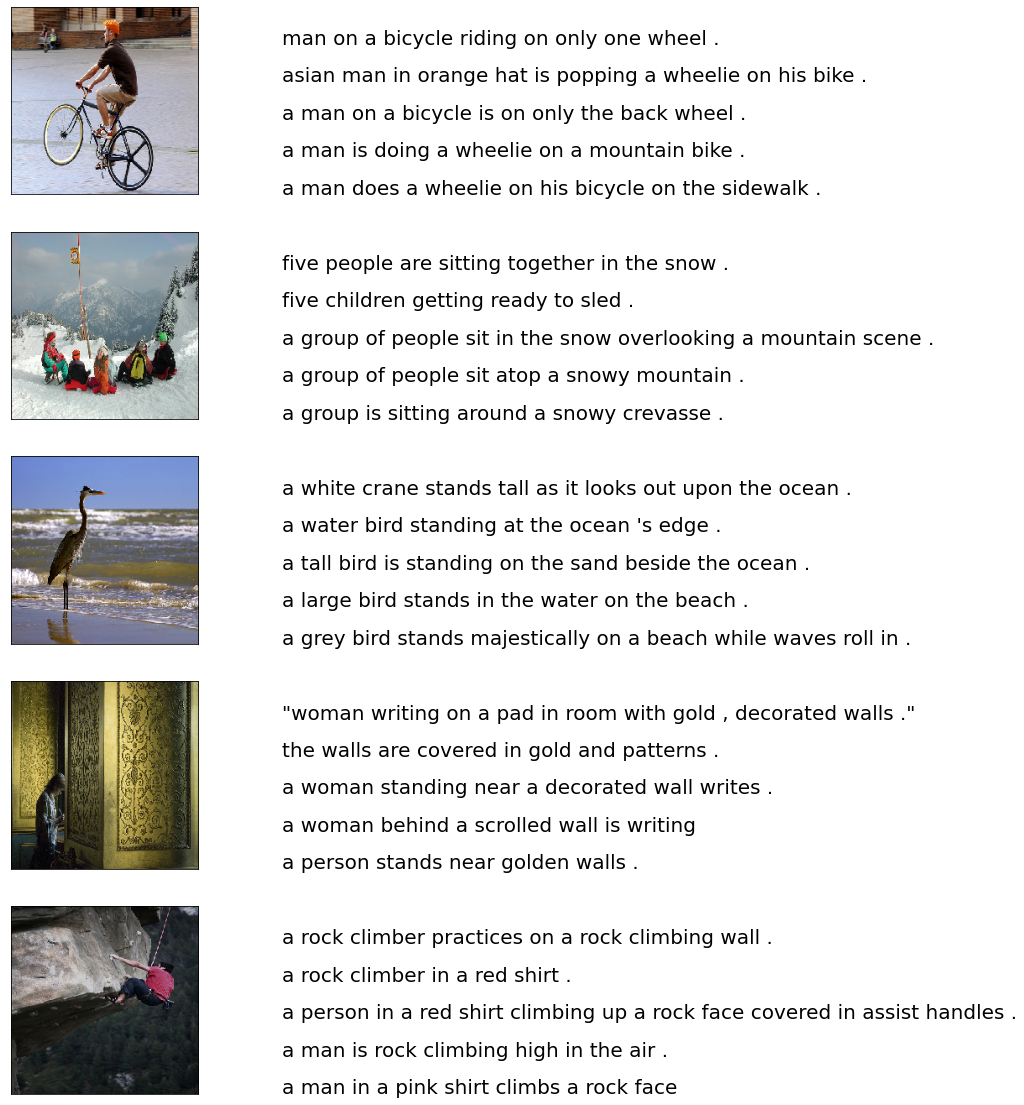

In [8]:
npic = 5 # no. of images to be displayed
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[-5:]:
    filename = dir_Flickr_imgs + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

# Data Preprocessing

### Analysing top words in captions

In [9]:
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt)
dfword.head()

Vocabulary Size: 9180


word  count
0    a  61752
1    .  34212
2   in  18965
3  the  18249
4   on  10732

### Cleaning captions for further analysis

The caption dataset contains punctuations, singular words and numerical values that need to be cleaned before it is fed to the model.

In [10]:
# Removing punctuations
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)

# Removing a single character word
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

# Removing words with numeric values
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [11]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)

for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption

### Plotting sample of top 20 words in cleaned dataset

Vocabulary Size: 8763


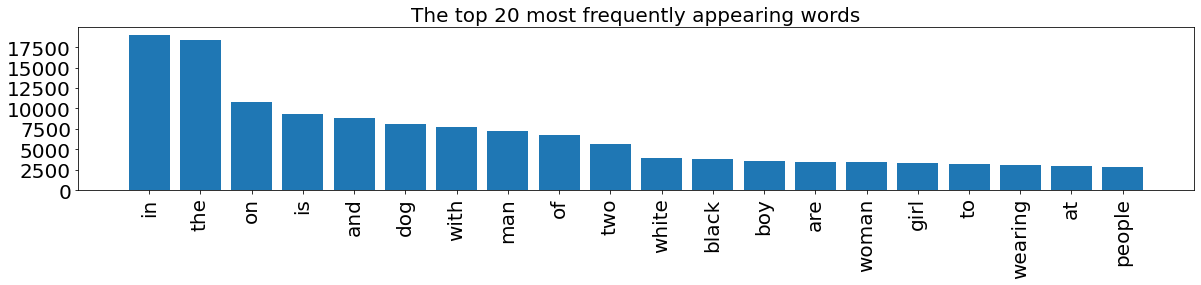

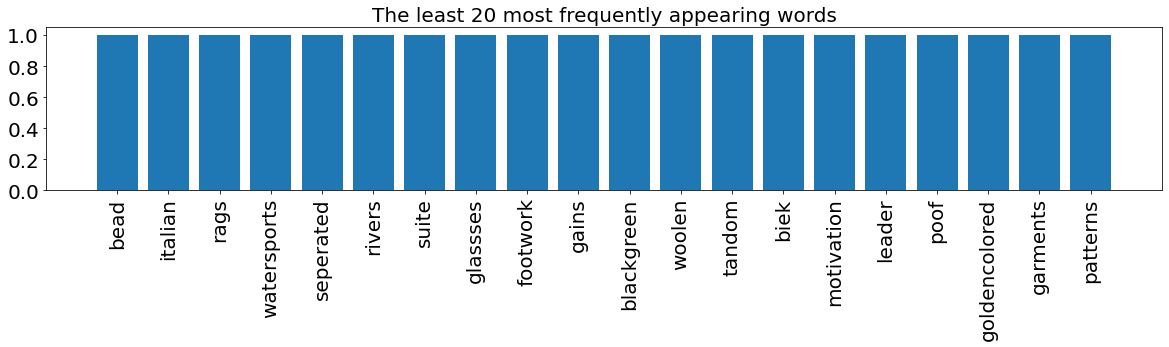

In [12]:
topn = 20 #no. of words to be plotted
def plthist(dfsub, title="The top %d most frequently appearing words" %topn):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()
dfword = df_word(df_txt)
plthist(dfword.iloc[:topn,:],
        title="The top %d most frequently appearing words" %topn)
plthist(dfword.iloc[-topn:,:],
        title="The least %d most frequently appearing words" %topn)

### Adding start and end sequence tokens

Adding start and end sequence makes it easier to identify the captions for the images as each of them are of different length

In [13]:
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt0.head(5)
df_txt

filename  index  \
0      1000268201_693b08cb0e.jpg      0   
1      1000268201_693b08cb0e.jpg      1   
2      1000268201_693b08cb0e.jpg      2   
3      1000268201_693b08cb0e.jpg      3   
4      1000268201_693b08cb0e.jpg      4   
...                          ...    ...   
40450   997722733_0cb5439472.jpg  40450   
40451   997722733_0cb5439472.jpg  40451   
40452   997722733_0cb5439472.jpg  40452   
40453   997722733_0cb5439472.jpg  40453   
40454   997722733_0cb5439472.jpg  40454   

                                                 caption  
0       child in pink dress is climbing up set of sta...  
1                        girl going into wooden building  
2             little girl climbing into wooden playhouse  
3       little girl climbing the stairs to her playhouse  
4       little girl in pink dress going into wooden c...  
...                                                  ...  
40450                 man in pink shirt climbs rock face  
40451               man is rock climbing high in the air  
40452   person in red shirt climbing up rock face cov...  
40453                          rock climber in red shirt  
40454       rock climber practices on rock climbing wall  

[40455 rows x 3 columns]

In [14]:
df_txt0[:5]

filename  index  \
0  1000268201_693b08cb0e.jpg      0   
1  1000268201_693b08cb0e.jpg      1   
2  1000268201_693b08cb0e.jpg      2   
3  1000268201_693b08cb0e.jpg      3   
4  1000268201_693b08cb0e.jpg      4   

                                             caption  
0  startseq  child in pink dress is climbing up s...  
1   startseq  girl going into wooden building endseq  
2  startseq  little girl climbing into wooden pla...  
3  startseq  little girl climbing the stairs to h...  
4  startseq  little girl in pink dress going into...

# Applying CNN model

### Loading VGG16 model and weights

In [15]:
modelvgg = VGG16(include_top=True,weights=None)
# load weights
modelvgg.load_weights("dataset/vgg16_weights_tf_dim_ordering_tf_kernels.h5")
modelvgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Deleting last layer of the model 

The last layer of the VGG-16 is excluded here because we are are just using it for extraction of features rather than using for object classification.

In [16]:
modelvgg.layers.pop()
modelvgg = models.Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-1].output)
modelvgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 138,357,544
Trainable params: 138,357,544
Non-trainable params: 0
_________________________________________________________________


## Feature extraction

In [17]:
images = OrderedDict()
npix = 224 #image size is fixed at 224 because VGG16 model is pre-trained
target_size = (npix,npix,3)
data = np.zeros((len(jpgs),npix,npix,3))
for i,name in enumerate(jpgs):
    # load an image from file
    filename = dir_Flickr_imgs + '/' + name
    image = load_img(filename, target_size=target_size)
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    nimage = preprocess_input(image)
    
    y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    images[name] = y_pred.flatten()

Here, the features are extracted from all the images in the dataset. VGG-16 model gives out 4096 features from the input image of size 224*224

### Plotting similar images from the dataset

For this we have to first create a cluster and find which images belong together. Hence, PCA is used to reduce the dimensions of the features which we got from VGG-16 feature extraction from **4096** to **2**

First, the clusters are plotted and few examples are taken from the bunch for displaying

In [18]:
encoder = np.array(list(images.values()))
pca = PCA(n_components=2)
y_pca = pca.fit_transform(encoder)

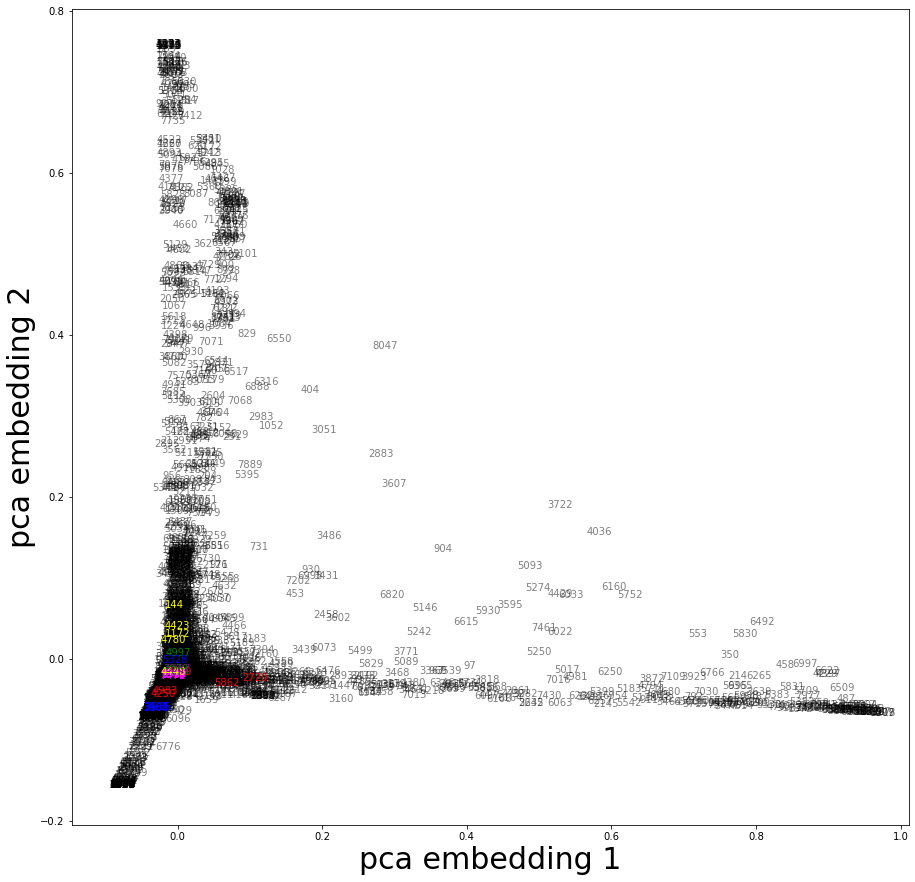

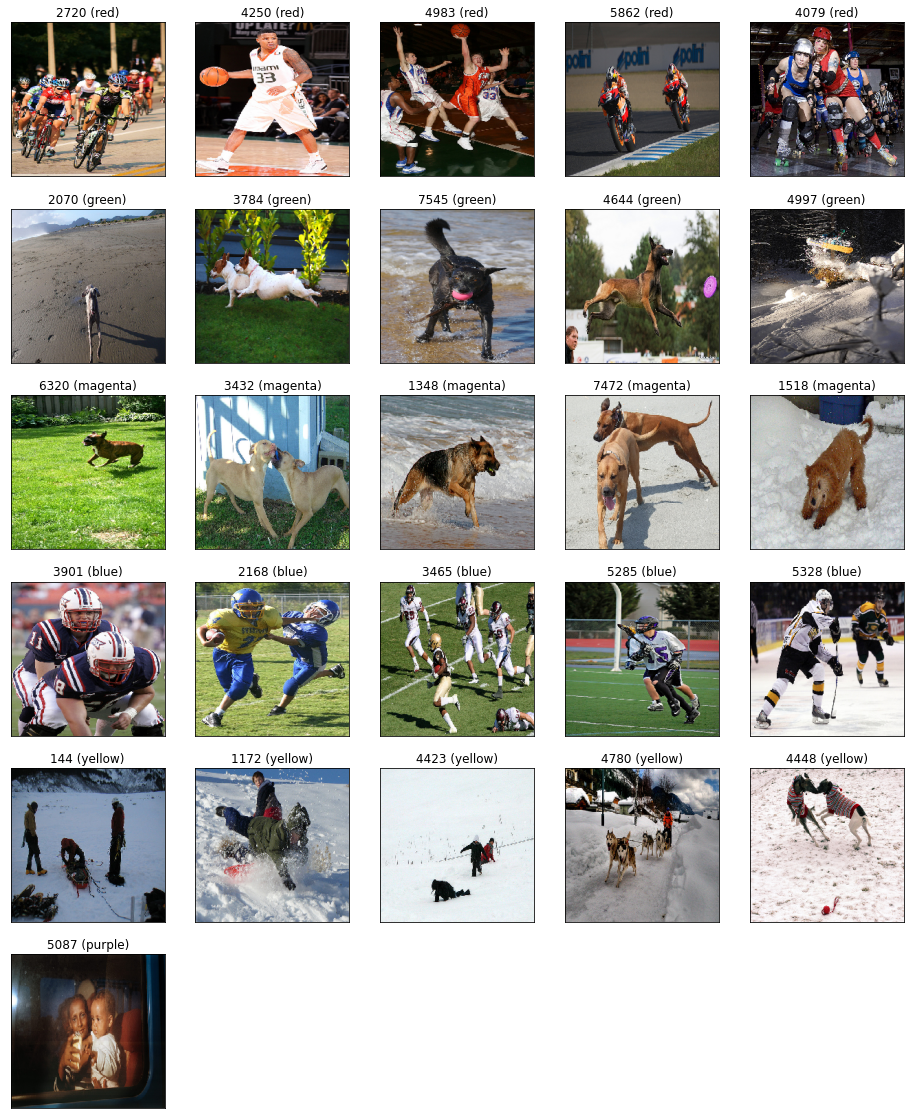

In [19]:
# some selected pictures that are creating clusters
picked_pic = OrderedDict()
picked_pic["red"]     = [2720,4250,4983,5862,4079]
picked_pic["green"]   = [2070,3784,7545,4644, 4997]
picked_pic["magenta"] = [6320,3432,1348,7472, 1518]
picked_pic["blue"]    = [3901,2168,3465,5285,5328]
picked_pic["yellow"]  = [144,1172,4423,4780,4448]
picked_pic["purple"]  = [5087]

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(y_pca[:,0],y_pca[:,1],c="white")

for irow in range(y_pca.shape[0]):
    ax.annotate(irow,y_pca[irow,:],color="black",alpha=0.5)
# annotate() is used to place text at the location of the point

for color, irows in picked_pic.items():
    for irow in irows:
        ax.annotate(irow,y_pca[irow,:],color=color)
ax.set_xlabel("pca embedding 1",fontsize=30)
ax.set_ylabel("pca embedding 2",fontsize=30)
plt.show()

# plotting images 
fig = plt.figure(figsize=(16,20))
count = 1
for color, irows in picked_pic.items():
    for ivec in irows:
        name = jpgs[ivec]
        filename = dir_Flickr_imgs + '/' + name
        image = load_img(filename, target_size=target_size)
    
        ax = fig.add_subplot(len(picked_pic),5,count,
                         xticks=[],yticks=[])
        count += 1
        plt.imshow(image)
        plt.title("{} ({})".format(ivec,color))
plt.show()

### Merging the images and the captions

In [20]:
to_drop = []
for i in range(len(df_txt0.filename)):
    if i % 5 != 0:
        to_drop.append(i)
df_txt0.drop(to_drop, inplace=True)

#fnames are the names of the image files        
fnames = df_txt0["filename"]
#dcaptions are the captions of the images 
dcaptions = df_txt0["caption"]

In [21]:
dimages=[]
for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])

#dimages are the actual features of the images
dimages = np.array(dimages)

In [22]:
df_txt0[:10]

filename  index  \
0   1000268201_693b08cb0e.jpg      0   
5   1001773457_577c3a7d70.jpg      5   
10  1002674143_1b742ab4b8.jpg     10   
15  1003163366_44323f5815.jpg     15   
20  1007129816_e794419615.jpg     20   
25  1007320043_627395c3d8.jpg     25   
30  1009434119_febe49276a.jpg     30   
35  1012212859_01547e3f17.jpg     35   
40  1015118661_980735411b.jpg     40   
45  1015584366_dfcec3c85a.jpg     45   

                                              caption  
0   startseq  child in pink dress is climbing up s...  
5   startseq  black dog and spotted dog are fighti...  
10  startseq  little girl covered in paint sits in...  
15  startseq  man lays on bench while his dog sits...  
20  startseq  man in an orange hat starring at som...  
25         startseq  child playing on rope net endseq  
30  startseq  black and white dog is running in gr...  
35  startseq  dog shakes its head near the shore r...  
40  startseq  boy smiles in front of stony wall in...  
45          startseq  black dog leaps over log endseq

### Tokenizing the captions for further processing

As the model can't take texts as an input, they are converted into vectors

In [23]:
nb_words = 6000 # max no. of words in dictionary
tokenizer = Tokenizer(nb_words=nb_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)

vocabulary size : 4476


In [24]:
dtexts[:5]

[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 522, 2],
 [1, 12, 8, 5, 752, 8, 17, 368, 2],
 [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2],
 [1, 10, 621, 6, 150, 27, 23, 8, 101, 46, 112, 2],
 [1, 10, 3, 24, 82, 96, 1199, 19, 162, 2]]

## Splitting the training and testing data

In [25]:
prop_test, prop_val = 0.2, 0.2 
# Pareto principle (80/20 split)

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

### Finding the maximum length of the caption

In [26]:
maxlen = np.max([len(text) for text in dtexts])
print(maxlen)

30


In [27]:
len(dt_train)

4855

In [28]:
len(dt_val)

1618

In [29]:
len(di_train)

4855

In [30]:
len(di_val)

1618

### Processing the captions and images as per the required shape of model

In [31]:
def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages))
    # using assert to make sure that length of images and captions are always similar
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):
        # zip() is used to create a tuple of iteratable items
        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            # using pad_sequences to make the length of all captions equal
            out_text = to_categorical(out_text,num_classes = vocab_size) 
            
            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)
# Xtext_test,  Ximage_test,  ytext_test  = preprocessing(dt_test,di_test)

# captions/images = 4855
 (49631, 30) (49631, 1000) (49631, 4476)
# captions/images = 1618
 (16353, 30) (16353, 1000) (16353, 4476)


# Stacked LSTM model

### Building Stacked LSTM model

In [75]:
# RELU - Reactified Linear Activation Function
print(vocab_size)

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)
# sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="CaptionFeature",return_sequences=True)(ftxt)
se2 = Dropout(0.04)(ftxt)
ftxt = layers.LSTM(256,name="CaptionFeature2")(se2)
# combined model for decoder
decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
model_s = models.Model(inputs=[input_image, input_txt],outputs=output)

model_s.compile(loss='categorical_crossentropy', optimizer='adam')

print(model_s.summary())

4476
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_50 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 30, 64)       286464      input_50[0][0]                   
__________________________________________________________________________________________________
CaptionFeature (LSTM)           (None, 30, 256)      328704      embedding_24[0][0]               
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 30, 256)      0           CaptionFeature[0][0]             
_______________________________________________________________________________________

### Training Stacked LSTM model

In [76]:
# fit model
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
#start = time.time()
hist_s = model_s.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=6, verbose=2, 
                  batch_size=32,
                  validation_data=([Ximage_val, Xtext_val], ytext_val),callbacks=[tensorboard])

Epoch 1/6
1551/1551 - 459s - loss: 5.3620 - val_loss: 4.8146
Epoch 2/6
1551/1551 - 353s - loss: 4.5201 - val_loss: 4.5649
Epoch 3/6
1551/1551 - 361s - loss: 4.1439 - val_loss: 4.4483
Epoch 4/6
1551/1551 - 436s - loss: 3.8781 - val_loss: 4.4540
Epoch 5/6
1551/1551 - 371s - loss: 3.6568 - val_loss: 4.5093
Epoch 6/6
1551/1551 - 383s - loss: 3.4621 - val_loss: 4.5714


### Generating captions on a sample set

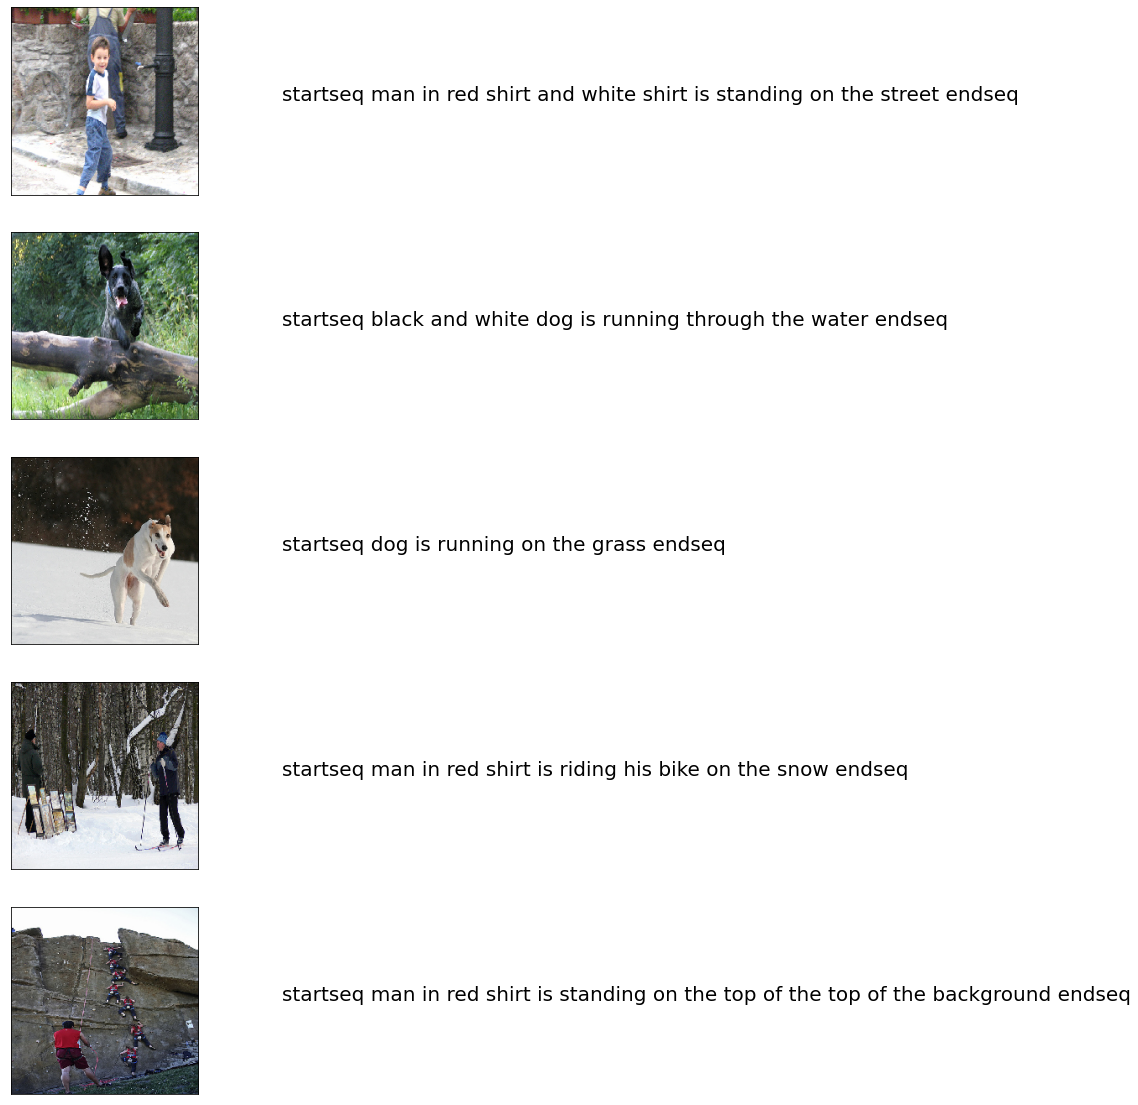

In [77]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model_s.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)

npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[8:13],di_test[8:13]): 
    filename = dir_Flickr_imgs + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

## Evaluating Stacked LSTM model performance

### Generating captions for the whole dataset

In [78]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])


nkeep = 5
pred_good, pred_bad, bleus_s = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]## remove startreg, and endreg
    
    bleu = sentence_bleu([caption_true],caption)
    bleus_s.append(bleu)
    if bleu > 0.7 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))

  12.36% is done..
  24.72% is done..
  37.08% is done..
  49.44% is done..
  61.80% is done..
  74.17% is done..
  86.53% is done..
  98.89% is done..


# Biconditional LSTM model

### Building Bi-LSTM model

In [61]:
# RELU - Reactified Linear Activation Function
print(vocab_size)

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(512,activation='relu',name="ImageFeature")(input_image)
# sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="CaptionFeature",return_sequences=True)(ftxt)
se2 = Dropout(0.04)(ftxt)
ftxt = layers.Bidirectional(layers.LSTM(256,name="CaptionFeature2"))(se2)

# combined model for decoder
decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
model = models.Model(inputs=[input_image, input_txt],outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

4476
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, 30, 64)       286464      input_44[0][0]                   
__________________________________________________________________________________________________
CaptionFeature (LSTM)           (None, 30, 256)      328704      embedding_21[0][0]               
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 30, 256)      0           CaptionFeature[0][0]             
_______________________________________________________________________________________

### Training Bi-LSTM model

In [65]:
# fit model
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
#start = time.time()
hist = model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=6, verbose=2, 
                  batch_size=32,
                  validation_data=([Ximage_val, Xtext_val], ytext_val),callbacks=[tensorboard])

Epoch 1/6
1551/1551 - 628s - loss: 5.4640 - val_loss: 5.0197
Epoch 2/6
1551/1551 - 514s - loss: 4.6921 - val_loss: 4.6562
Epoch 3/6
1551/1551 - 500s - loss: 4.2217 - val_loss: 4.5147
Epoch 4/6
1551/1551 - 495s - loss: 3.9015 - val_loss: 4.4590
Epoch 5/6
1551/1551 - 491s - loss: 3.6607 - val_loss: 4.5110
Epoch 6/6
1551/1551 - 510s - loss: 3.4432 - val_loss: 4.5921


### Generating captions on a sample set

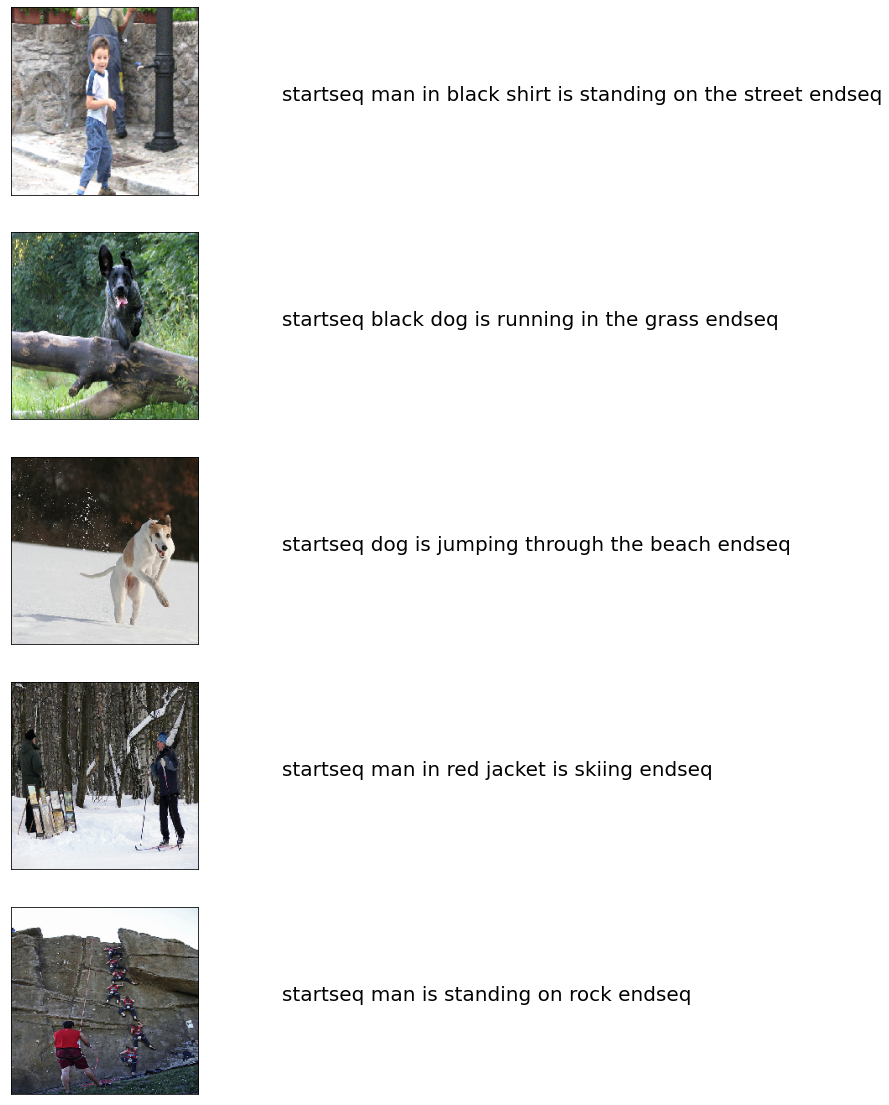

In [66]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)

npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[8:13],di_test[8:13]): 
    filename = dir_Flickr_imgs + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

## Evaluating Bi-LSTM model performance

### Generating captions for the whole dataset

In [70]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])


nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]## remove startreg, and endreg
    
    bleu = sentence_bleu([caption_true],caption)
    bleus.append(bleu)
    if bleu > 0.7 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))

  12.36% is done..
  24.72% is done..
  37.08% is done..
  49.44% is done..
  61.80% is done..
  74.17% is done..
  86.53% is done..
  98.89% is done..


# Good and bad captions examples

Bad Caption


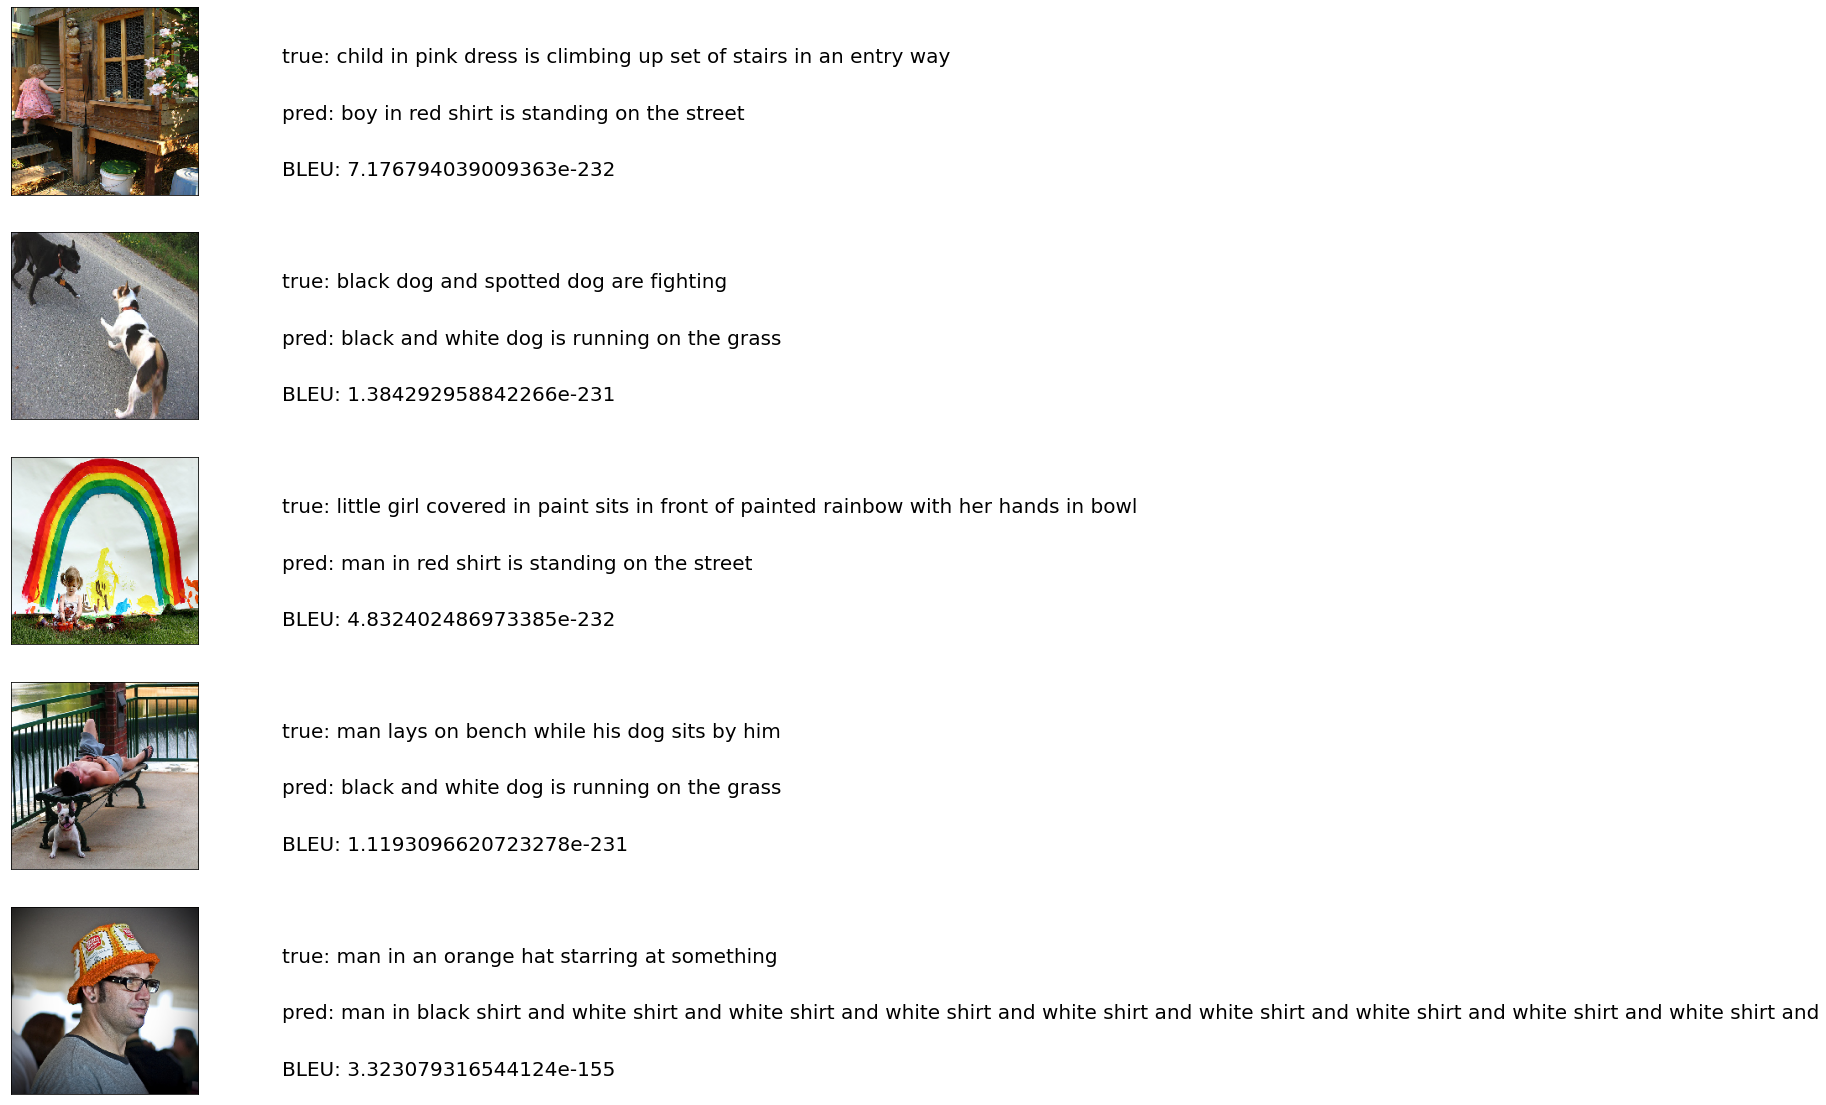

Good Caption


<Figure size 720x1440 with 0 Axes>

In [87]:
%matplotlib inline
def plot_images(pred_bad):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_bad)
    for pb in pred_bad:
        bleu,jpgfnm,caption_true,caption = pb
        ## images 
        filename = dir_Flickr_imgs + '/' + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"true:" + caption_true,fontsize=20)
        ax.text(0,0.4,"pred:" + caption,fontsize=20)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=20)
        count += 1
    plt.show()

print("Bad Caption")
plot_images(pred_bad)
print("Good Caption")
plot_images(pred_good)